In [2]:
import os
import zipfile
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms as transforms
from torchvision.models import vgg19
from torch import optim

Matplotlib is building the font cache; this may take a moment.


In [3]:
print("MPS available:", torch.backends.mps.is_available())

MPS available: True


In [4]:
device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Constants
BATCH_SIZE = 16
LR = 3e-4
EPOCHS = 20
IMG_CHANNELS = 3
low_res_size = 128
high_res_size = 256

In [12]:
# Extracting Dataset
def extract_dataset(zip_path, extract_to="dataset"):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Dataset extracted.")

extract_dataset("/Users/arman/Desktop/Atml_mini_project/dataset_for_mini_project.zip", "data")


Dataset extracted.


In [9]:
# Defining image transformation
transform_low = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((low_res_size, low_res_size)),
    transforms.ToTensor()
])

transform_high = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((high_res_size, high_res_size)),
    transforms.ToTensor()
])

In [10]:
# Creating custom dataset class
class ImageDataset(Dataset):
    def __init__(self, root_dir, csv_file):
        super(ImageDataset, self).__init__()
        self.root_dir = root_dir
        self.data = pd.read_csv(csv_file)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        low_res_name = self.data.iloc[index]['low_res']
        high_res_name = self.data.iloc[index]['high_res']
        
        low_res_path = os.path.join(self.root_dir, 'low res', low_res_name)
        high_res_path = os.path.join(self.root_dir, 'high res', high_res_name)
        
        low_res = np.array(Image.open(low_res_path))[:, :, :3]
        high_res = np.array(Image.open(high_res_path))[:, :, :3]
        
        low_res = transform_low(low_res)
        high_res = transform_high(high_res)
        
        return low_res, high_res

In [13]:
# Initialize Dataset and DataLoader
dataset_path = "/Users/arman/Desktop/Atml_mini_project/myenv/data/Image Super Resolution - Unsplash"
csv_file_path = os.path.join(dataset_path, '/Users/arman/Desktop/Atml_mini_project/myenv/data/Image Super Resolution - Unsplash/image_data.csv')
train_dataset = ImageDataset(root_dir=dataset_path, csv_file=csv_file_path)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
# Defining GAN model components
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_activation=True, use_BatchNorm=True, **kwargs):
        super().__init__()
        self.use_activation = use_activation
        self.cnn = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels) if use_BatchNorm else nn.Identity()
        self.ac = nn.LeakyReLU(0.2, inplace=True)
    def forward(self, x):
        x = self.cnn(x)
        x = self.bn(x)
        if self.use_activation:
            x = self.ac(x)
        return x

class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=8):
        super().__init__()
        self.initial = ConvBlock(in_channels, num_channels, kernel_size=7, stride=1, padding=3, use_BatchNorm=False)
        self.res_blocks = nn.Sequential(*[ConvBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1) for _ in range(num_blocks)])
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.final = nn.Conv2d(num_channels, in_channels, kernel_size=7, stride=1, padding=3)
    def forward(self, x):
        x = self.initial(x)
        x = self.res_blocks(x)
        x = self.upsample(x)
        x = self.final(x)
        return torch.sigmoid(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        layers = []
        for feature in features:
            layers.append(ConvBlock(in_channels, feature, kernel_size=4, stride=2, padding=1))
            in_channels = feature
        self.blocks = nn.Sequential(*layers)
        self.fc = nn.Linear(512*16*16, 1)
    def forward(self, x):
        x = self.blocks(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

In [15]:
gen = Generator().to(device)
disc = Discriminator().to(device)
opt_gen = optim.Adam(gen.parameters(), lr=LR)
opt_disc = optim.Adam(disc.parameters(), lr=LR)
criterion = nn.BCEWithLogitsLoss()

# Step 6: Training Loop
def train_fn(loader, gen, disc, opt_gen, opt_disc, criterion):
    for epoch in range(EPOCHS):
        for low_res, high_res in tqdm(loader):
            low_res, high_res = low_res.to(device), high_res.to(device)

            # Train Discriminator
            fake = gen(low_res)
            disc_real = disc(high_res)
            disc_fake = disc(fake.detach())
            loss_disc = (criterion(disc_real, torch.ones_like(disc_real)) + criterion(disc_fake, torch.zeros_like(disc_fake))) / 2
            opt_disc.zero_grad()
            loss_disc.backward()
            opt_disc.step()

            # Train Generator
            disc_fake = disc(fake)
            loss_gen = criterion(disc_fake, torch.ones_like(disc_fake))
            opt_gen.zero_grad()
            loss_gen.backward()
            opt_gen.step()

        print(f"Epoch [{epoch+1}/{EPOCHS}] Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}")



In [16]:
train_fn(train_loader, gen, disc, opt_gen, opt_disc, criterion)

100%|██████████| 236/236 [01:38<00:00,  2.41it/s]


Epoch [1/20] Loss D: 1.5539, loss G: 2.3360


100%|██████████| 236/236 [01:46<00:00,  2.22it/s]


Epoch [2/20] Loss D: 2.3656, loss G: 0.1508


100%|██████████| 236/236 [01:53<00:00,  2.09it/s]


Epoch [3/20] Loss D: 0.0000, loss G: 21.3328


100%|██████████| 236/236 [02:01<00:00,  1.95it/s]


Epoch [4/20] Loss D: 0.0000, loss G: 15.7700


100%|██████████| 236/236 [02:09<00:00,  1.83it/s]


Epoch [5/20] Loss D: 0.0201, loss G: 15.0880


100%|██████████| 236/236 [02:07<00:00,  1.85it/s]


Epoch [6/20] Loss D: 2.2394, loss G: 13.5736


100%|██████████| 236/236 [02:12<00:00,  1.79it/s]


Epoch [7/20] Loss D: 0.0003, loss G: 14.8963


100%|██████████| 236/236 [02:12<00:00,  1.78it/s]


Epoch [8/20] Loss D: 0.0020, loss G: 3.3668


100%|██████████| 236/236 [02:13<00:00,  1.76it/s]


Epoch [9/20] Loss D: 0.1316, loss G: 25.5135


100%|██████████| 236/236 [02:14<00:00,  1.75it/s]


Epoch [10/20] Loss D: 0.0337, loss G: 5.4810


100%|██████████| 236/236 [02:13<00:00,  1.76it/s]


Epoch [11/20] Loss D: 2.0764, loss G: 5.6784


100%|██████████| 236/236 [02:11<00:00,  1.80it/s]


Epoch [12/20] Loss D: 0.0151, loss G: 11.2824


100%|██████████| 236/236 [02:13<00:00,  1.77it/s]


Epoch [13/20] Loss D: 1.2882, loss G: 8.3487


100%|██████████| 236/236 [02:15<00:00,  1.75it/s]


Epoch [14/20] Loss D: 2.1180, loss G: 15.1431


100%|██████████| 236/236 [02:11<00:00,  1.79it/s]


Epoch [15/20] Loss D: 1.4539, loss G: 9.1899


100%|██████████| 236/236 [02:14<00:00,  1.76it/s]


Epoch [16/20] Loss D: 0.1825, loss G: 10.1176


100%|██████████| 236/236 [02:17<00:00,  1.72it/s]


Epoch [17/20] Loss D: 9.6213, loss G: 9.9564


100%|██████████| 236/236 [02:16<00:00,  1.73it/s]


Epoch [18/20] Loss D: 3.3395, loss G: 2.9102


100%|██████████| 236/236 [02:19<00:00,  1.69it/s]


Epoch [19/20] Loss D: 5.4668, loss G: 18.4417


100%|██████████| 236/236 [02:16<00:00,  1.73it/s]

Epoch [20/20] Loss D: 0.5709, loss G: 2.3473


In [17]:
import matplotlib.pyplot as plt

def plot_generated_images(generator, dataset, num_images=5):
    # Set generator to evaluation mode
    generator.eval()

    # Sample a few images from the dataset
    data_loader = DataLoader(dataset, batch_size=num_images, shuffle=True)
    low_res, high_res = next(iter(data_loader))

    # Move to device
    low_res = low_res.to(device)

    # Generate high-resolution images
    with torch.no_grad():
        generated_hr = generator(low_res)

    # Move tensors back to CPU for visualization
    low_res = low_res.cpu()
    generated_hr = generated_hr.cpu()
    high_res = high_res.cpu()

    # Plot images
    fig, axs = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))
    for i in range(num_images):
        # Display low-resolution input
        axs[i, 0].imshow(low_res[i].permute(1, 2, 0).numpy())
        axs[i, 0].set_title("Low-Resolution Input")
        axs[i, 0].axis("off")

        # Display generated high-resolution image
        axs[i, 1].imshow(generated_hr[i].permute(1, 2, 0).numpy())
        axs[i, 1].set_title("Generated High-Resolution")
        axs[i, 1].axis("off")

        # Display ground truth high-resolution image (optional)
        axs[i, 2].imshow(high_res[i].permute(1, 2, 0).numpy())
        axs[i, 2].set_title("Ground Truth High-Resolution")
        axs[i, 2].axis("off")

    plt.show()

    # Set the generator back to training mode
    generator.train()

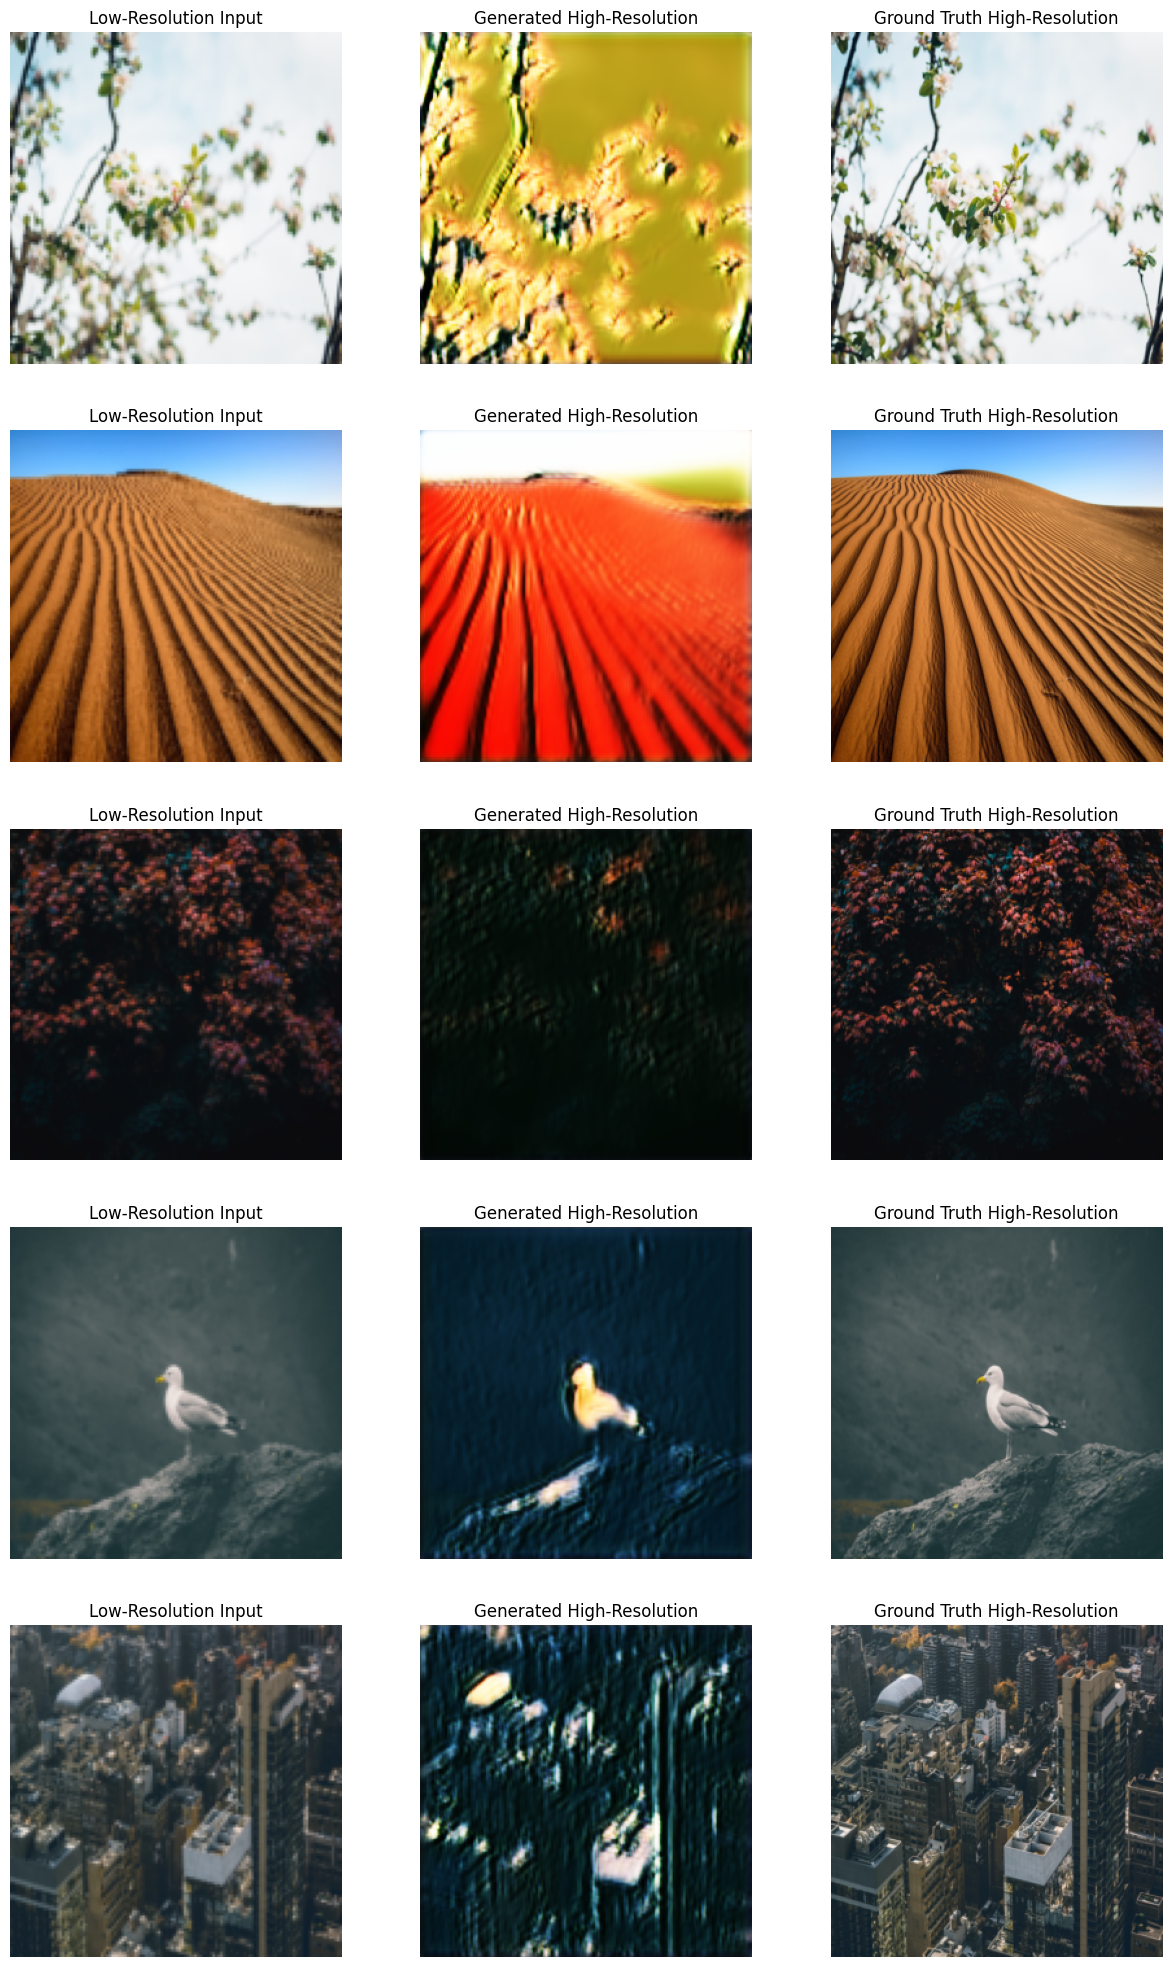

In [18]:
plot_generated_images(generator=gen, dataset=train_dataset, num_images=5)